In [4]:
import pandas as pd
import json
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib
from clearml import Task, TaskTypes, Dataset

# Connect clearml

In [5]:
task = Task.init(
    project_name="numenta_anomaly_detection",
    task_name="training",
    reuse_last_task_id=False,
    task_type=TaskTypes.training,
)


ClearML Task: created new task id=f5a5b0ec915d4668a7591be33f3c03f4
2023-04-04 20:39:45,852 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2023-04-04 20:39:46,036 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/8e19acc82b2d415e922149ef4e48800b/experiments/f5a5b0ec915d4668a7591be33f3c03f4/output/log


## Load processed data

In [6]:
df = pd.read_csv("../data/processed/temperature_data_processed.csv", parse_dates=['timestamp'], index_col='timestamp')

In [7]:
df.shape

(22695, 2)

In [8]:
df.head()

,value,anomaly
timestamp,,
2013-12-02 21:15:00,73.967322,1
2013-12-02 21:20:00,74.935882,1
2013-12-02 21:25:00,76.124162,1
2013-12-02 21:30:00,78.140707,1
2013-12-02 21:35:00,79.329836,1


## Split data into train and test

In [9]:
train_data, test_data = train_test_split(df,
                                        test_size=0.6,
                                        random_state=42,
                                        shuffle=False)

In [10]:
train_data.shape, test_data.shape

((9078, 2), (13617, 2))

In [11]:
train_data.head()

,value,anomaly
timestamp,,
2013-12-02 21:15:00,73.967322,1
2013-12-02 21:20:00,74.935882,1
2013-12-02 21:25:00,76.124162,1
2013-12-02 21:30:00,78.140707,1
2013-12-02 21:35:00,79.329836,1


## Train an isolation forest model

In [12]:
model = IsolationForest(n_estimators=100, contamination=0.01)

In [13]:
clf = Pipeline([('scaler', StandardScaler()), ('model', model)])
clf.fit(train_data['value'].values.reshape(-1, 1))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', IsolationForest(contamination=0.01))])

## Evaluate the model

In [14]:
test_data.loc[:, 'prediction'] = clf.predict(test_data['value'].values.reshape(-1, 1))

In [15]:
test_data.head()

,value,anomaly,prediction
timestamp,,,
2014-01-03 09:45:00,89.234590,1,1
2014-01-03 09:50:00,90.176975,1,1
2014-01-03 09:55:00,88.711917,1,1
2014-01-03 10:00:00,89.904685,1,1
2014-01-03 10:05:00,88.845390,1,1


In [16]:
test_data['anomaly'].value_counts()

 1    12483
-1     1134
Name: anomaly, dtype: int64

In [17]:
test_data['prediction'].value_counts()

 1    13150
-1      467
Name: prediction, dtype: int64

## Plot results

In [18]:
with open("../data/labels/combined_windows.json") as window_file:
    windows = json.loads(window_file.read())

In [19]:
windows = windows["realKnownCause/machine_temperature_system_failure.csv"]

d:\LDA\playground\mlops-platform-evaluation\.venv\lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:92: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



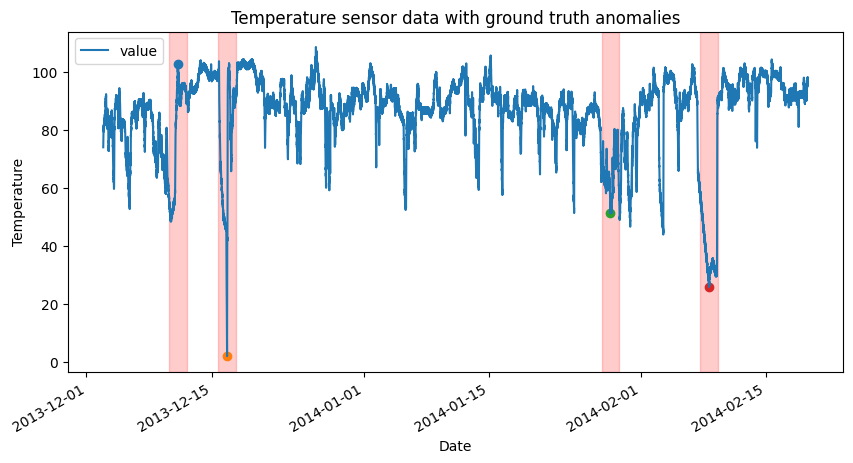

In [20]:
ax = df['value'].plot(figsize=(10,5))
for window in windows:
    ax.axvspan(xmin=window[0], xmax=window[1], alpha=0.2, color='red')
    df_slice = df[(df.index >= window[0]) & (df.index <= window[1])]
    idx = df_slice.shape[0] // 2
    ax.scatter(x=df_slice.index[idx], y=df_slice.iloc[idx]['value'])
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature sensor data with ground truth anomalies')
plt.show()

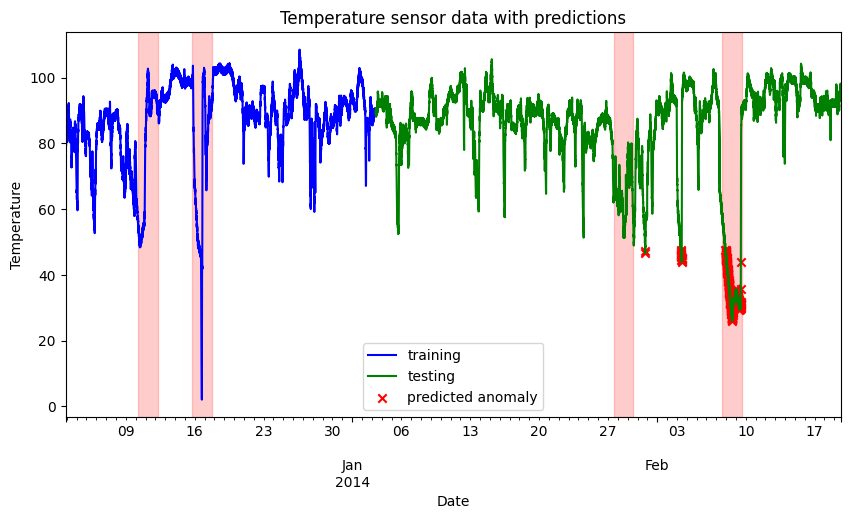

In [21]:
ax = train_data['value'].plot(figsize=(10,5), label='training', color='blue')
ax = test_data['value'].plot(figsize=(10,5), label='testing', color='green')
for window in windows:
    ax.axvspan(xmin=window[0], xmax=window[1], alpha=0.2, color='red')
    df_slice = df[(df.index >= window[0]) & (df.index <= window[1])]
predictions = test_data[test_data["prediction"] == -1]
ax.scatter(predictions.index, predictions['value'], color='red', label='predicted anomaly', marker='x')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature sensor data with predictions')
plt.show()

In [22]:
y_pred = clf.predict(test_data[['value']])

# Compute the F1 score
f1 = f1_score(test_data['anomaly'], y_pred, pos_label=-1)

print(f'F1 score: {f1}')

d:\LDA\playground\mlops-platform-evaluation\.venv\lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



F1 score: 0.5596502186133666


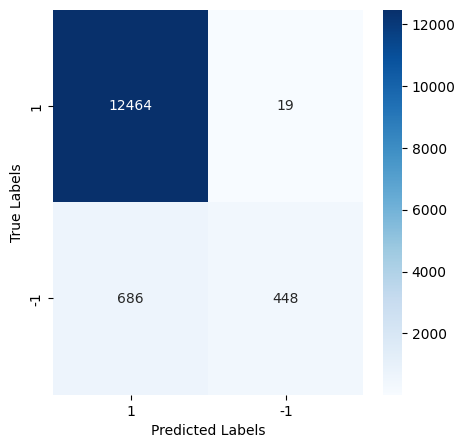

In [23]:
# Compute the confusion matrix
cm = confusion_matrix(test_data['anomaly'], y_pred, labels=[1, -1])

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['1', '-1'], yticklabels=['1', '-1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save the model

In [24]:
filename = '../models/isolation_forest.joblib'
joblib.dump(clf, filename)

['../models/isolation_forest.joblib']

# Load the model

In [25]:
clf = joblib.load(filename)
y_pred = clf.predict(test_data[['value']])

# Compute the F1 score
f1 = f1_score(test_data['anomaly'], y_pred, pos_label=-1)

print(f'F1 score: {f1}')

d:\LDA\playground\mlops-platform-evaluation\.venv\lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



F1 score: 0.5596502186133666
